# Feature Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />


## Table of Contents

* [1.1 Environment Setup](#env-setup)
    * [1.1.1 Importing Modules](#imports)
    * [1.1.2 Display Settings](#display-setup)
    * [1.1.3 Load Data](#read-file)
<br><br>
* [1.2 Exploratory Data Analysis](#eda)
    * [1.2.1 Grouping Variables by Type](#var-type)
    * [1.2.2 Remove Abnormal Sales](#ras)
    * [1.2.3 Combining Number Basement Bathrooms](#cnbb)
    * [1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations](#rnf)
    * [1.2.5 Remove Nominal Variables With Less Than 10% of Unique Observations](#rnf)
    * [1.2.6 Converting Ordinal Variables to Numeric](#covn)
    * [1.2.7 Dummifying Nominal Variables](#dnr)
    * [1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)](#imcm)
    * [1.2.9 Correlation Against Target Variable (SalePrice)](#catv)
    * [1.2.10 Checking for Normality: Dependent Variable](#cndv)
    * [1.2.11 Checking for Normality: Independent Variables](#cniv)
<br><br>
* [1.3 Feature Selection](#fs)
    * [1.3.1 Using Lasso Regression to Select Features](#lasso)
<br><br>
* [1.4 Descriptive Modeling](#dm)
    * [1.4.1 Train and Test data](#ttd)
    * [1.4.2 Multiple Linear Regression with all the features](#mlr)
    * [1.4.3 Multiple Linear Regresion with limited number of features](#mlr2)
    * [1.4.4 Evaluating p-values and R-squared using Statmodels](#statmodel)
    * [1.4.5 Further narrowing of the number of features](#fnnf)
<br><br>
* [1.5 Evaluating Overall Quality, Fence, and Roof](#eval-section)
    * [1.5.1 Roof Material](#roof-material)
    * [1.5.2 Fence Quality](#fence-quality)
    * [1.5.3 Overall Quality of the House](#overall-quality)

### 1.1 Environment Setup  <a class="anchor" id="env-setup"></a>

#### 1.1.1 Importing Modules<a class="anchor" id="imports"></a>

In [242]:
# import modules
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
import statsmodels.formula.api as smf
from scipy import stats
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

#### 1.1.2 Display Settings<a class="anchor" id="display-setup"></a>

In [243]:
pd.set_option('display.max_columns', None) # display all the columns of a dataframe
pd.set_option('display.max_rows', 100)     # display 100 rows of a dataframe

#### 1.1.3 Load data<a class="anchor" id="read-file"></a>

In [244]:
# Load cleaned data - see "Data Cleansing.ipynb"
dataset = pd.read_csv('../ariel/Price_Data_cleaned.csv')

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.2 Exploratory Data Analysis <a class="anchor" id="eda"></a>

#### 1.2.1 Grouping Variables by Type<a class="anchor" id="var-type"></a>

In [245]:
continuous_variables = ['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF',
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                       'SalePrice', 'LotFrontage']

discrete_variables = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
                      'MoSold', 'YrSold']

nominal_variables = ['MSSubClass', 'Alley', 'LandContour', 'MSZoning', 'LotConfig', 'Neighborhood',
                     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Street', 'Heating',
                     'GarageType', 'CentralAir', 'MiscFeature', 'SaleType', 'SaleCondition']

ordinal_variables = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
                     'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 'BsmtFinType2', 'Electrical',
                     'BsmtFinType1','BsmtExposure', 'LandSlope', 'Utilities', 'LotShape',]


#### 1.2.2 Remove Abnormal Sales<a class="anchor" id="ras"></a>
<br>
Only include sales that were completed under 'normal' circumstances. The other type of sales (foreclosure, short sale, etc...) only account for 6% of the observations.

In [246]:
dataset = dataset[dataset['SaleCondition']=='Normal']

In [247]:
# Drop SaleCondition since all the sales are now 'Normal'
dataset.drop(columns='SaleCondition', inplace=True)

#### 1.2.3 Combining Number Basement Bathrooms<a class="anchor" id="cnbb"></a>

In [248]:
# Combine BsmtFullBath and BsmtHalfBath
dataset['BsmtNumBath'] = dataset['BsmtFullBath'] + dataset['BsmtHalfBath'] / dataset['BsmtHalfBath'].max()
# Total number of bathrooms above grade
dataset['TotalNumBath'] = dataset['FullBath'] + dataset['HalfBath'] / dataset['HalfBath'].max()
# Drop orginal features
dataset.drop(columns=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], inplace=True)

#### 1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations<a class="anchor" id="rnf"></a>

In [249]:
# Removing the following features since they are only present in less than 20% of the observations
((dataset.select_dtypes(['int','float'])==0).sum()/dataset.shape[0]).sort_values(ascending=False).head(10)


PoolArea         0.996270
3SsnPorch        0.988396
LowQualFinSF     0.987153
MiscVal          0.961044
ScreenPorch      0.912143
BsmtFinSF2       0.867799
EnclosedPorch    0.839619
MasVnrArea       0.615416
2ndFlrSF         0.562785
BsmtNumBath      0.522586
dtype: float64

In [250]:
dataset.drop(columns=['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal','ScreenPorch','BsmtFinSF2','EnclosedPorch'], axis=1, inplace=True)

#### 1.2.5 Remove Nominal Variables With Less Than 10% of Unique Observations<a class="anchor" id="rnf"></a>

In [251]:
# Removing the following nominal variables since they are only present in less than 20% of the observations.
((dataset.select_dtypes('object')=='None').sum()/2413).sort_values(ascending=False).head(10)

PoolQC          0.996270
MiscFeature     0.960215
Alley           0.936179
Fence           0.791960
MasVnrType      0.618317
FireplaceQu     0.482387
GarageCond      0.048073
GarageQual      0.048073
GarageFinish    0.048073
GarageType      0.048073
dtype: float64

In [252]:
dataset.drop(columns=['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

#### 1.2.6 Converting Ordinal Variables to Numeric<a class="anchor" id="covn"></a>

In [253]:
# Encoding Ordinal Variables
dict_1 = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
dict_2 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
dict_3 = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
dict_4 = {"None":0, "Unf":1, "RFn":2, "Fin":3}
dict_5 = {"N":1, "P":2, "Y":3}
dict_6 = {"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4}
dict_7 = {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8}
dict_8 = {"Mix":1, "FuseP":2, "FuseF":3, "FuseA":4, "SBrkr":5}
dict_9 = {"Sev":1, "Mod":2, "Gtl":3}
dict_10 = {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}
dict_11 = {"IR3":1, "IR2":2, "IR1":3, "Reg":4}

dataset.BsmtExposure.replace(dict_1, inplace=True)
dataset.ExterQual.replace(dict_2, inplace=True)
dataset.ExterCond.replace(dict_2, inplace=True)
dataset.BsmtQual.replace(dict_2, inplace=True)
dataset.BsmtCond.replace(dict_2, inplace=True)
dataset.HeatingQC.replace(dict_2, inplace=True)
dataset.KitchenQual.replace(dict_2, inplace=True)
dataset.FireplaceQu.replace(dict_2, inplace=True)
dataset.GarageQual.replace(dict_2, inplace=True)
dataset.GarageCond.replace(dict_2, inplace=True)
# dataset.PoolQC.replace(dict_2, inplace=True)
dataset.BsmtFinType1.replace(dict_3, inplace=True)
dataset.BsmtFinType2.replace(dict_3, inplace=True)
#dataset.GarageFinish.replace(dict_4, inplace=True)
dataset.PavedDrive.replace(dict_5, inplace=True)
dataset.Fence.replace(dict_6, inplace=True)
dataset.Functional.replace(dict_7, inplace=True)
dataset.Electrical.replace(dict_8, inplace=True)
dataset.LandSlope.replace(dict_9, inplace=True)
dataset.Utilities.replace(dict_10, inplace=True)
dataset.LotShape.replace(dict_11, inplace=True)

#### 1.2.7 Dummifying Nominal Variables<a class="anchor" id="dnr"></a>

In [35]:
# update the nominal_variables list by removing the columns removed in the previous section
nominal_variables_updated = list(set(nominal_variables)-set(['PoolQC', 'MiscFeature', 'Alley', 'SaleCondition']))

In [36]:
# set the MSSubClass column to object, since it is a nominal variable
dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)
# new dataset that will hold the encoded categorical variables + all the others
dataset_encoded = dataset.copy()
# Encode all categorical nominal variables
for column_name in nominal_variables_updated:
    dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded[column_name], prefix=column_name, drop_first=True)], axis=1)
# Remove original categorical columns
dataset_encoded = dataset_encoded.drop(nominal_variables_updated, axis=1)

#### 1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)<a class="anchor" id="imcm"></a>

In [37]:
continuous_variables_updated = list(set(continuous_variables)-set(['MiscVal', 'ScreenPorch', '3SsnPorch', 'LowQualFinSF', 'PoolArea','BsmtFinSF2','EnclosedPorch']))

In [38]:
# Generate correlation matrix (continues variables only)
corr_matrix = dataset[continuous_variables_updated].corr(method="pearson") # pearson? kendall? which is best

In [39]:
# List of highly (>0.85) correlated pair of variables
c_m = list(corr_matrix.columns)
for index_ in corr_matrix.columns:
    c_m.remove(index_)
    for feature in c_m:
        if abs(corr_matrix.loc[index_,feature])>0.85:
            print(index_,"_",feature,": ",corr_matrix.loc[index_,feature], sep="")

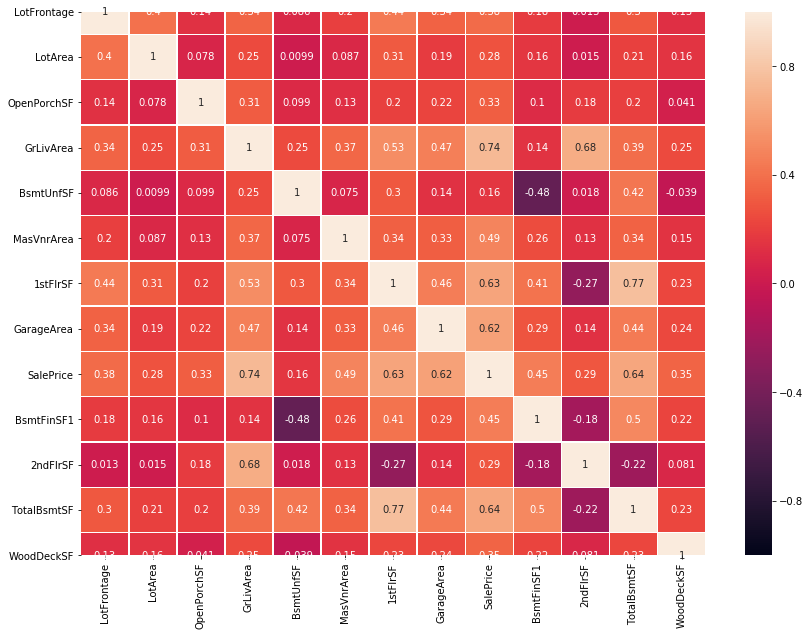

In [40]:
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.5, annot=True)

<b>Conclusion:</b> correlation between features is within reasonable values, no feature will be removed.

#### 1.2.9 Correlation Against Target Variable (SalePrice)<a class="anchor" id="catv"></a>

In [41]:
# Remove features with low correlation (<0.01) with the target variable(SalePrice)
corr_matrix['SalePrice'].abs().sort_values(ascending=False)

SalePrice      1.000000
GrLivArea      0.736036
TotalBsmtSF    0.642354
1stFlrSF       0.634672
GarageArea     0.621900
MasVnrArea     0.486620
BsmtFinSF1     0.454087
LotFrontage    0.382420
WoodDeckSF     0.350127
OpenPorchSF    0.326489
2ndFlrSF       0.293338
LotArea        0.275066
BsmtUnfSF      0.159724
Name: SalePrice, dtype: float64

<b>Conslusion:</b> no features will be removed since correlation between target variable and features is within reasonable values.


#### 1.2.10 Checking for Normality: Dependent Variable<a class="anchor" id="cndv"></a>

variable = y
Median: 159000.0
Mean: 175567.64318276005
Skew: 1.7453580480340125
Kurtosis: 5.825763749688768
--------------------------------------------------
variable = log10(y)
Median: 5.201397124320452
Mean: 5.244444479212366
Skew: 0.24188453291963574
Kurtosis: 0.7653528688452214


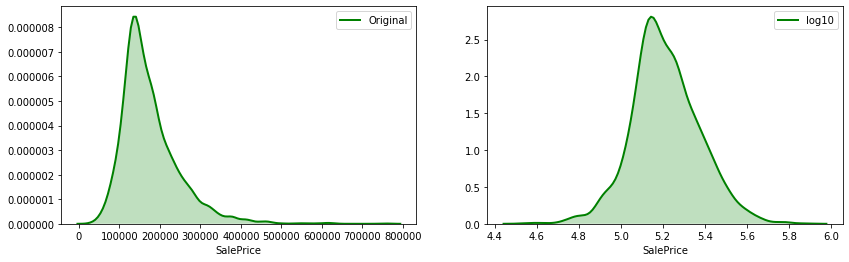

In [42]:
# Check Target variable for normal distribution
print('variable = y')
print("Median: " + str(dataset_encoded['SalePrice'].median()))
print("Mean: " + str(dataset_encoded['SalePrice'].mean()))
print("Skew: " + str(dataset_encoded['SalePrice'].skew()))
print("Kurtosis: " + str(dataset_encoded['SalePrice'].kurtosis()))
print("-"*50)
# log10
print("variable = log10(y)")
print("Median: " + str(np.log10(dataset_encoded['SalePrice'].median())))
print("Mean: " + str(np.log10(dataset_encoded['SalePrice'].mean())))
print("Skew: " + str(np.log10(dataset_encoded['SalePrice'].skew())))
print("Kurtosis: " + str(np.log10(dataset_encoded['SalePrice'].kurtosis())))
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2, figsize=(14,4)) 
sns.distplot(dataset_encoded['SalePrice'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original", color ="green", ax = ax[0]) 
sns.distplot(np.log10(dataset_encoded['SalePrice']), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "log10", color ="green", ax = ax[1])


<b>Conclusion:</b> Calculating the log10 of the target variable produces a distribution closer to the normal distribution.

#### 1.2.11 Checking for Normality: Independent Variables<a class="anchor" id="cniv"></a>

In [43]:
# Continuous variables -> skewness
cont_var_skew = pd.DataFrame((dataset_encoded[continuous_variables_updated]).skew().abs()).reset_index()
cont_var_log_skew = pd.DataFrame(np.log10(dataset_encoded[continuous_variables_updated]+1).skew().abs()).reset_index()
cont_var_skew.columns = ['feature','skewness']
cont_var_log_skew.columns = ['feature','skewness_log']
cont_skew = cont_var_skew.merge(cont_var_log_skew, on="feature", how="inner")
cont_skew

,feature,skewness,skewness_log
0,LotFrontage,1.137594,1.112926
1,LotArea,13.393921,0.513180
2,OpenPorchSF,2.269634,0.000086
3,GrLivArea,0.940956,0.036984
4,BsmtUnfSF,0.978891,2.129723
5,MasVnrArea,2.750254,0.586703
6,1stFlrSF,1.043301,0.024600
7,GarageArea,0.192519,3.738757
8,SalePrice,1.745358,0.155859
9,BsmtFinSF1,0.746737,0.738851


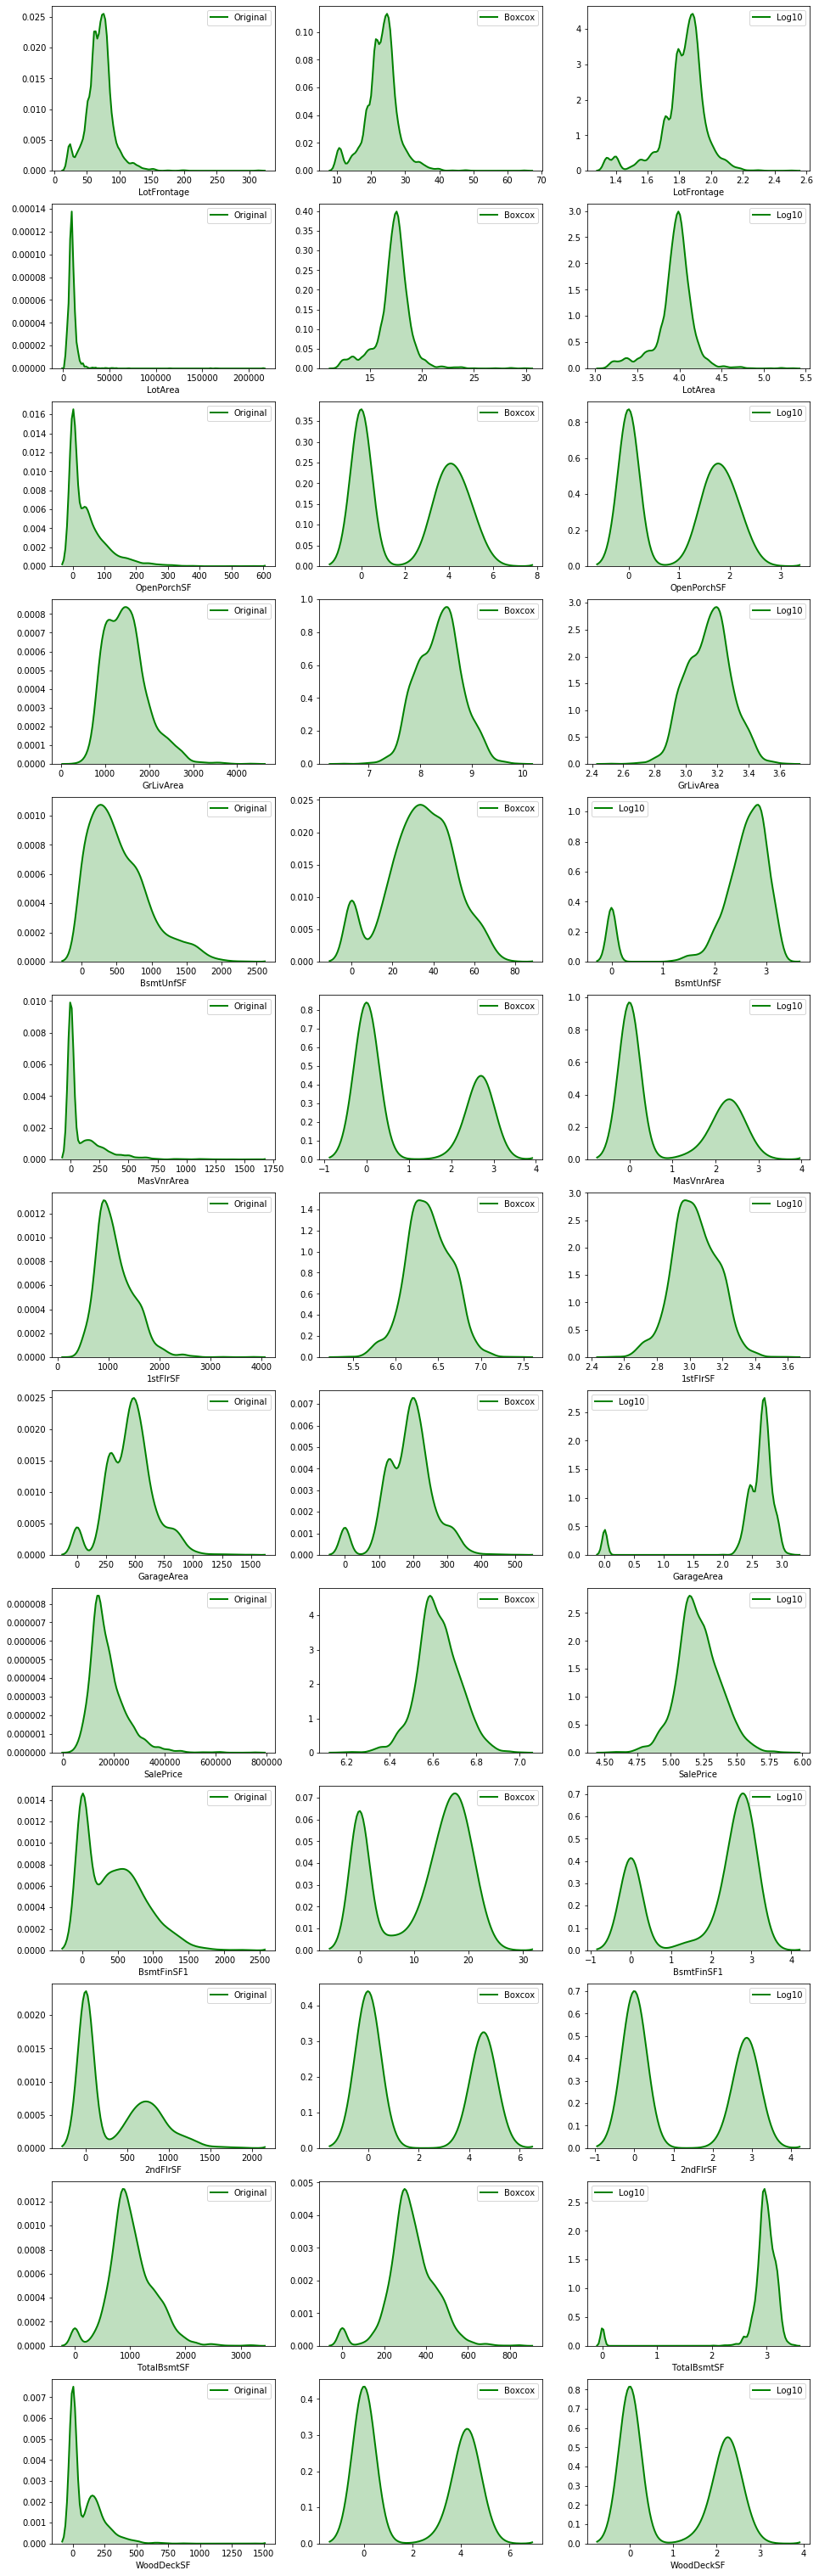

In [44]:
# creating axes to draw plots: 3 plots per feature
fig, ax = plt.subplots(dataset_encoded[continuous_variables_updated].shape[1], 3,  figsize=(16,55))
# Plot original data, boxcox, and log10
for i,feature in enumerate(continuous_variables_updated):
    original_data = dataset_encoded[feature]+1
    sns.distplot(original_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Original", color ="green", ax = ax[i,0]) 

    fitted_data, fitted_lambda = stats.boxcox(original_data) 
    sns.distplot(fitted_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Boxcox", color ="green", ax = ax[i,1]) 

    sns.distplot(np.log10(original_data), hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Log10", color ="green", ax = ax[i,2])

<b>Conclusion:</b> we will take the log10 of the following features: 1stFirSF, GrLivArea, and LotArea

In [45]:
# Take log10 of GrLivArea, LotArea, and 1stFlrSF
dataset_encoded['log10_GrLivArea'] = np.log10(dataset_encoded['GrLivArea'])
dataset_encoded['log10_LotArea'] = np.log10(dataset_encoded['LotArea'])
dataset_encoded['log10_1stFlrSF'] = np.log10(dataset_encoded['1stFlrSF']+1)     # +1 : This means we are adding bias, but is needed for zero
# Remove original columns
dataset_encoded.drop(columns=['GrLivArea','LotArea','1stFlrSF'], inplace=True)

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.3 Feature Selection<a class="anchor" id="fs"></a>

#### 1.3.1 Using Lasso Regression to Select Features<a class="anchor" id="lasso"></a>

In [46]:
X = dataset_encoded.drop('SalePrice',axis=1)  # features
y = dataset_encoded['SalePrice']              # target
X_norm = MinMaxScaler().fit_transform(X)      # Transform features by scaling each feature to a given range (0,1).

In [47]:
# Using Lasso to select features
clf = LassoCV(alphas=np.arange(0.0001, 0.01)).fit(X_norm, y)   # set alpha low to ensure the features will have more relevance
importance = np.abs(clf.coef_)

In [48]:
# create dataframe Feature - Importance
features =[]
scores = []
for i, feature in enumerate(X.columns):
    if importance[i]>0:
        features.append(feature)
        scores.append(importance[i])
# dataframe
feature_score = pd.DataFrame.from_dict({"feature":features,"Score":scores})

In [49]:
# top 20 features with highest importance value
lasso_generated_features = list(feature_score.sort_values(by="Score", ascending=False).head(20)['feature'])

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.4 Descriptive Modeling<a class="anchor" id="dm"></a>

#### 1.4.1 Train and Test data<a class="anchor" id="ttd"></a>

In [50]:
# dataset -> Includes all features - Ordinal features encoded, Nominal features not dummified.
# dataset_encoded.shape -> Includes all features - Ordinal and Nominal features encoded/dummified.
# X -> Same as dataset_encoded without SalePrice feature
# Y -> Same as dataset_encoded but only SalePrice feature
# X_norm -> Same as X but all the numerical values scaled (0,1)

In [51]:
# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

#### 1.4.2 Multiple Linear Regression with all the features<a class="anchor" id="mlr"></a>

In [52]:
# Create model: Multiple Linear Regression
mlr_model = LinearRegression()
mlr_model.fit(X_train,np.log(y_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
# # Calculate R-squared (score) using Training data
mlr_model.score(X_train,np.log(y_train))

0.9596248164084863

In [54]:
# Calculate R-squared (score) using Test data
mlr_model.score(X_test,np.log(y_test))

0.9353804149586177

#### 1.4.3 Multiple Linear Regresion with limited number of features<a class="anchor" id="mlr2"></a>

In [55]:
# Fit model with training data using Lasso generated features (top 20)
mlr_model.fit(X_train[lasso_generated_features], np.log10(y_train))
# Calculate R-squared (score) using training data
mlr_model.score(X_train[lasso_generated_features], np.log10(y_train))

0.9179264811441009

In [56]:
# Calculate R-squared (score) using test data
mlr_model.score(X_test[lasso_generated_features], np.log10(y_test))

0.9149734652660044

In [57]:
# Coefficients for features
for i, name_c in enumerate(lasso_generated_features):
    print(name_c +":  " + "{:.6f}". format(mlr_model.coef_[i]))

log10_1stFlrSF:  0.224389
TotalBsmtSF:  0.000078
Condition2_PosA:  0.054751
2ndFlrSF:  0.000071
Exterior2nd_PreCast:  0.097989
Neighborhood_GrnHill:  0.176245
log10_LotArea:  0.103514
OverallQual:  0.040563
RoofMatl_WdShngl:  0.019533
Condition2_PosN:  0.058600
MasVnrArea:  0.000028
YearBuilt:  0.001515
GarageType_None:  -0.031375
log10_GrLivArea:  0.181632
OverallCond:  0.021578
Heating_OthW:  -0.052824
Exterior1st_PreCast:  0.097989
BsmtUnfSF:  -0.000044
BsmtCond:  0.005654
Condition2_RRAn:  0.000000


#### 1.4.4 Evaluating p-values and R-squared using Statmodels<a class="anchor" id="statmodel"></a>

In [58]:
dataset_encoded.rename(columns={'2ndFlrSF':'FlrSF2nd'})

,SalePrice,LotFrontage,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,FlrSF2nd,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,BsmtNumBath,TotalNumBath,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,CentralAir_Y,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LandContour_HLS,LandContour_Low,LandContour_Lvl,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,log10_GrLivArea,log10_LotArea,log10_1stFlrSF
0,126000,64.0,4,4,3,6,6,1939,1950,0.0,3,3,3,3,1,3,238.0,1,618.0,856.0,3,5,0,2,1,3,4,8,1,4,1939.0,1,2.0,399.0,3,3,3,0,0,0,3,2010,1.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2.932474,3.897077,2.932981
1,139500,42.0,4,4,3,5,5,1984,1984,149.0,4,3,4,3,2,6,552.0,5,104.0,1049.0,3,5,0,2,1,4,5,8,0,0,1984.0,3,1.0,266.0,3,3,3,0,105,0,2,2009,1.0,2.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [59]:
# Statmodels does not like feature names starting with a number
X_stat = dataset_encoded.rename(columns={'2ndFlrSF':'FlrSF2nd'})
y_stat = dataset['SalePrice']
# Split data 70/30
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat, y_stat, test_size=0.30, random_state=10)
smf_model_features = lasso_generated_features
smf_model_features[3] = 'FlrSF2nd'

In [60]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.918
Model:                             OLS   Adj. R-squared:                  0.917
Method:                  Least Squares   F-statistic:                     1038.
Date:                 Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                         13:03:33   Log-Likelihood:                 2771.4
No. Observations:                 1689   AIC:                            -5505.
Df Residuals:                     1670   BIC:                            -5402.
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

In [61]:
# Decided to remove the following features whose Statistical Significance is low and some of the nominal features
smf_model_features = set(lasso_generated_features) - set(['Condition2_PosA','RoofMatl_WdShngl',
                                                          'Condition2_PosN','Heating_OthW','Condition2_RRAn'])#,'BsmtCond'])
                                                          #'Neighborhood_GrnHill','Exterior1st_PreCast','GarageType_None']) 

In [62]:
# Let's try again
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.918
Model:                             OLS   Adj. R-squared:                  0.917
Method:                  Least Squares   F-statistic:                     1331.
Date:                 Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                         13:03:35   Log-Likelihood:                 2767.5
No. Observations:                 1689   AIC:                            -5505.
Df Residuals:                     1674   BIC:                            -5424.
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

#### 1.4.5 Further narrowing of the number of features<a class="anchor" id="fnnf"></a>

In [63]:
import itertools

In [64]:
%%time
scores_models = {}
for features in itertools.combinations(smf_model_features, len(smf_model_features)-7):
    results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(features), data=X_train_stat).fit()
    scores_models[features] = results.rsquared_adj

CPU times: user 12min 32s, sys: 6 s, total: 12min 38s
Wall time: 2min 8s


In [65]:
Keymax = max(scores_models, key=scores_models.get) 
print(Keymax)

('log10_GrLivArea', 'OverallQual', 'OverallCond', 'BsmtUnfSF', 'log10_LotArea', 'GarageType_None', 'YearBuilt', 'TotalBsmtSF')


In [66]:
scores_models[('OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond', 'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF', 'log10_LotArea')]

KeyError: ('OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond', 'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF', 'log10_LotArea')

In [57]:
# Let's try again
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(['log10_GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'log10_LotArea', 'BsmtUnfSF', 'OverallCond', 'OverallQual']), data=dataset_encoded).fit()
# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.911
Model:                             OLS   Adj. R-squared:                  0.910
Method:                  Least Squares   F-statistic:                     3506.
Date:                 Thu, 26 Nov 2020   Prob (F-statistic):               0.00
Time:                         18:43:19   Log-Likelihood:                 3898.0
No. Observations:                 2413   AIC:                            -7780.
Df Residuals:                     2405   BIC:                            -7734.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1811      

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.5 Evaluating Overall Quality, Fence, and Roof<a class="anchor" id="eval-section"></a>

In [ ]:
# 'OverallQual', 'OverallCond', 'PavedDrive', 'Fence','RoofStyle', 'RoofMatl'

#### 1.5.1 Roof Material<a class="anchor" id="roof-material"></a>

<h4>Roof material</h4>
<p>&nbsp;</p>
<table style="border-collapse: collapse; width: 46.0227%; height: 162px;" border="1">
<thead>
<tr style="border-style: ridge; height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Abbreviation</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Material</td>
</tr>
</thead>
<tbody>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">ClyTile</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Clay or Tile</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">CompShg</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Standard (Composite) Shingle</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Membran</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Membrane</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Metal</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Metal</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Roll</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Roll</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Tar&amp;Grv</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Gravel &amp; Tar</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">WdShake</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Wood Shakes</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">WdShngl</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Wood Shingles</td>
</tr>
</tbody>
</table>

In [73]:
roof_matl_dict = ({"ClyTile":"Clay or Tile","CompShg":"Standard (Composite) Shingle","Membran":"Membrane",
                   "Metal":"Metal","Roll":"Roll","Tar&Grv":"Gravel & Tar","WdShake":"Wood Shakes",
                   "WdShngl":"Wood Shingles",})

In [ ]:
roofmatl_count = dataset.groupby(['RoofMatl']).agg({"RoofMatl":"count"})/dataset.shape[0]*100
roofmatl_count.columns = ['Number of Houses']
roofmatl_count.reset_index(inplace=True)
roofmatl_count.columns=["Roof Material",'Percentage of Houses']
roofmatl_count['Roof Material'].replace(roof_matl_dict, inplace=True)

In [82]:
roofmatl_count.style.applymap(lambda x: 'color: red' if (x<0.05) else 'color: black', subset=['Percentage of Houses']).hide_index()

Roof Material,Percentage of Houses
Standard (Composite) Shingle,98.6738
Membrane,0.0414422
Metal,0.0414422
Roll,0.0414422
Gravel & Tar,0.621633
Wood Shakes,0.290095
Wood Shingles,0.290095


<ul>
<li>Not enough houses have <span style="color: #ff0000;">Metal</span>, <span style="color: #ff0000;">Roll</span>, or <span style="color: #ff0000;">Membrane</span> as Roof Material to evaluate them. It is not possible to see a pattern to determine if these roof materials would add or subtract value from the base price of the house.</li>
<li>Most houses have Standard (Composite) Shingle as the roofing material.</li>
</ul>

We are going to evaluate how much the sale price of the house changes when the roof material is replaced with Grave & Tar, Wood Shakes or Wood Shingles.

In [235]:
dataset.groupby(['RoofMatl']).agg({"RoofMatl":"count"})

,RoofMatl
RoofMatl,
CompShg,2381
Membran,1
Metal,1
Roll,1
Tar&Grv,15
WdShake,7
WdShngl,7


In [250]:
#dataset[(dataset['RoofMatl']=='CompShg') & (dataset['SalePrice']>270000) & (dataset['SalePrice']<290001)].sort_values(by='SalePrice') #.unique()

In [84]:
dataset[dataset['RoofMatl']=='WdShngl'].sort_values(by='SalePrice')#.unique()

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,SaleType,BsmtNumBath,TotalNumBath
2190,1350,168500,80,RL,82.0,9020,Pave,4,Lvl,4,Corner,3,NAmes,Feedr,Norm,1Fam,SLvl,6,5,1964,1964,Gable,WdShngl,Plywood,Wd Sdng,BrkFace,259.0,3,3,CBlock,3,3,4,6,624.0,3,288.0,1248.0,GasA,3,Y,5,1350,0,3,1,3,6,8,0,0,Attchd,1964.0,2,2.0,520.0,3,3,3,176,0,4,6,2008,WD,1.0,1.5
538,2524,278000,20,RL,80.0,9600,Pave,4,Lvl,4,Inside,3,NWAmes,PosN,Norm,1Fam,1Story,8,5,1981,1981,Hip,WdShngl,BrkFace,BrkFace,None,0.0,4,3,PConc,4,3,1,5,1104.0,1,1420.0,2524.0,GasA,3,Y,5,2524,0,4,1,4,9,8,1,4,Attchd,1981.0,3,2.0,542.0,3,3,3,474,120,3,7,2009,WD,1.0,2.5
1626,1743,279000,20,RL,155.0,20064,Pave,3,Low,4,Inside,1,ClearCr,Norm,Norm,1Fam,1Story,8,6,1976,1976,Shed,WdShngl,Wd Sdng,Wd Sdng,None,0.0,4,3,CBlock,4,4,4,2,51.0,6,0.0,966.0,GasA,5,Y,5,1743,0,0,1,4,5,8,2,2,Attchd,1976.0,3,2.0,529.0,3,3,3,646,0,0,5,2007,WD,2.0,0.5
1954,1533,280000,20,RL,62.0,70761,Pave,3,Low,4,Inside,2,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,3,3,CBlock,4,3,4,5,655.0,1,878.0,1533.0,GasA,3,Y,5,1533,0,2,1,4,5,8,2,3,Attchd,1975.0,1,2.0,576.0,3,3,3,200,54,0,12,2006,WD,1.0,2.0
347,1842,385000,20,RL,68.0,50271,Pave,3,Low,4,Inside,3,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,4,3,CBlock,5,3,4,6,1810.0,1,32.0,1842.0,GasA,4,Y,5,1842,0,0,1,4,5,8,1,4,Attchd,1981.0,3,3.0,894.0,3,3,3,857,72,0,11,2006,WD,2.0,0.5
2003,3608,475000,75,RM,90.0,22950,Pave,2,Lvl,4,Inside,3,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,4,4,BrkTil,3,3,2,1,0.0,1,1107.0,1107.0,GasA,5,Y,5,1518,1518,4,1,5,12,8,2,3,Detchd,1993.0,1,3.0,840.0,5,3,3,0,260,4,6,2006,WD,0.0,2.5
1007,4316,755000,60,RL,104.0,21535,Pave,3,Lvl,4,Corner,3,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,5,3,PConc,5,3,4,6,1455.0,1,989.0,2444.0,GasA,5,Y,5,2444,1872,4,1,5,10,8,2,5,Attchd,1994.0,3,3.0,832.0,3,3,3,382,50,0,1,2007,WD,0.5,3.5


In [175]:
df_roof = pd.concat([dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']],pd.get_dummies(dataset['RoofMatl'])], axis=1)

In [176]:
# Remove observations for houses with Metal, Membran or Roll. (One house for each)
df_roof.drop(index=df_roof[(df_roof['Metal']==1)].index[0], inplace=True)
df_roof.drop(index=df_roof[(df_roof['Membran']==1)].index[0], inplace=True)
df_roof.drop(index=df_roof[(df_roof['Roll']==1)].index[0], inplace=True)
df_roof.drop(columns=['Membran','Metal','Roll'], inplace=True)

In [195]:
df_roof.rename(columns={"Tar&Grv":"TarGrv"}, inplace=True)

In [215]:
# Model to evaluate roof material
mlr_model_roof = LinearRegression()
mlr_model_roof.fit(df_roof.drop(columns=['SalePrice']), np.log10(df_roof['SalePrice']))
mlr_model_roof.score(df_roof.drop(columns=['SalePrice']), np.log10(df_roof['SalePrice']))

0.9137925342245923

In [226]:
# Predict the sale price of a house with different roof materials
# df_roof[df_roof['CompShg']==1].head(10).drop(columns=['SalePrice'])#,'TarGrv','WdShake','WdShngl'])
houses_to_predict = df_roof[df_roof['CompShg']==1].head(4)
mlr_model_roof.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.05385153, 5.11549829, 5.11652676, 4.97707169])

In [227]:
houses_to_predict

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea,CompShg,TarGrv,WdShake,WdShngl
0,6,2,2.932474,6,1939,618.0,856.0,126000,3.897077,1,0,0,0
1,5,2,3.020775,5,1984,104.0,1049.0,139500,3.626853,1,0,0,0
2,5,2,3.000434,9,1930,100.0,837.0,124900,3.782473,1,0,0,0
3,4,2,3.016616,8,1900,405.0,405.0,114000,3.910944,1,0,0,0


In [223]:
print(10**5.05385153)
print(10**5.11549829)
print(10**5.11652676)
print(10**4.97707169)

113201.33015670952
130466.28316235903
130775.61166779378
94857.50338643852


In [230]:
houses_to_predict['CompShg']=0
houses_to_predict['TarGrv']=1

In [232]:
mlr_model_roof.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.05946811, 5.12111487, 5.12214335, 4.98268828])

In [233]:
print(10**5.05946811)
print(10**5.12111487)
print(10**5.12214335)
print(10**4.98268828)

114674.83132459615
132164.51603951218
132477.8740137215
96092.23174430412


In [251]:
houses_to_predict['TarGrv']=0
houses_to_predict['WdShake']=1

In [252]:
mlr_model_roof.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.03706615, 5.09871291, 5.09974138, 4.96028631])

In [253]:
print(10**5.03706615)
print(10**5.09871291)
print(10**5.09974138)
print(10**4.96028631)

108909.59674460991
125519.99405228219
125817.595173593
91261.22835938397


In [254]:
houses_to_predict['WdShake']=0
houses_to_predict['WdShngl']=1

In [255]:
mlr_model_roof.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.07892685, 5.14057361, 5.14160208, 5.00214701])

In [256]:
print(10**5.07892685)
print(10**5.14057361)
print(10**5.14160208)
print(10**5.00214701)

119929.72835783094
138220.86611400277
138548.58031646637
100495.59133350274


#### 1.5.2 Fence Quality<a class="anchor" id="fence-quality"></a>

<p><strong>Fence Quality</strong></p>
<table style="border-collapse: collapse; width: 44.472%; height: 103px;" border="1">
<thead>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;"><em><strong>Rating</strong></em></td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;"><em><strong>Quality</strong></em></td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: center;"><em><strong>Description</strong></em></td>
</tr>
</thead>
<tbody>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">4</td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;">GdPrv</td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: left;">&nbsp; Good Privacy</td>
</tr>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">3</td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;">MnPrv</td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: left;">&nbsp; Minimum Privacy</td>
</tr>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">2</td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;">GdWo</td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: left;">&nbsp; Good Wood</td>
</tr>
<tr style="height: 13px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">1</td>
<td style="width: 8.26072%; height: 13px; border-style: ridge; text-align: center;">MnWw</td>
<td style="width: 38.401%; height: 13px; border-style: ridge; text-align: left;">&nbsp; Minimum Wood/Wire</td>
</tr>
<tr style="height: 18px;">
<td style="width: 8.16763%; border-style: ridge; text-align: center;">0</td>
<td style="width: 8.26072%; height: 18px; border-style: ridge; text-align: center;">NA</td>
<td style="width: 38.401%; height: 18px; border-style: ridge; text-align: left;">&nbsp; No Fence</td>
</tr>
</tbody>
</table>

In [307]:
df_fence = (dataset.groupby('Fence').agg(count=pd.NamedAgg(column="Fence", aggfunc="count"))/dataset.shape[0]*100).reset_index()
df_fence.columns=['Fence Rating','Percentage of Houses']
df_fence.style.hide_index()

Fence Rating,Percentage of Houses
0,79.196022
1,0.414422
2,4.102777
3,11.852466
4,4.434314


#### 1.5.3 Overall Quality of the House<a class="anchor" id="overall-quality"></a>

In [260]:
dataset['OverallQual'].value_counts()

5     715
6     640
7     493
8     256
4     185
9      64
3      32
10     15
2      10
1       3
Name: OverallQual, dtype: int64

<br><br><br><br>

<hr>

#### Linear Model

<b>Ava: </b>'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'

<b>Khamanna: </b>'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'GarageFinish', GarageQual', 'GarageCond',

<b>Ariel:</b>'OverallQual', 'OverallCond', 'PavedDrive', 'Fence', 'RoofStyle', 'RoofMatl',

<b>Shay: </b>'HeatingQC', 'CentralAir', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'LowQualFinSF'
 
y = beta0 + beta1*X1 + beta2*X2 + beta3*X3 + beta4*X4 ...+ betan*Xn(Exterior Quality)

1) Garage -> 'GarageFinish', 'GarageQual', 'GarageCond'
2) Exterior -> 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd'

1) Basement -> 'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'
2) 'Fireplaces', 'FireplaceQu', 

1) Overall Condition -> 'OverallQual', 'OverallCond',
2) RoofStyle, RoofMatl

1) AC -> 'HeatingQC', 'CentralAir'
2) 'KitchenAbvGr', 'KitchenQual'
3) 'LowQualFinSF'

In [ ]:
dataset[dataset['RoofMatl']=="WdShngl"]

## Evaluating Exterior and Garage

In [ ]:
exterior_matl_dict = ({ 'AsbShng':'Asbestos Shingles','AsphShn':'Asphalt Shingles','BrkComm':'Brick Common',\
                          'BrkFace':'Brick Face','CBlock':'Cinder Block','CemntBd':'Cement Board',\
                          'HdBoard':'Hard Board','ImStucc':'Imitation Stucco','MetalSd':'Metal Siding',\
                          'Other':'Other','Plywood':'Plywood','PreCast':'PreCast','Stone':'Stone',
                          'Stucco':'Stucco','VinylSd':'Vinyl Siding','Wd Sdng':'Wood Siding',\
                          'WdShing':'Wood Shingles'})

In [111]:
exteriormatl_count = dataset.groupby(['Exterior2nd']).agg({"Exterior2nd":"count"})/dataset.shape[0]*100
exteriormatl_count.columns = ['Number of Houses']
exteriormatl_count.reset_index(inplace=True)
exteriormatl_count.columns=["Exterior",'Percentage of Houses']
exteriormatl_count['Exterior'].replace(exterior_matl_dict, inplace=True)
exteriormatl_count.style.applymap(lambda x: 'color: red' if (x<1) else 'color: black', \
                              subset=['Percentage of Houses']).hide_index()

Exterior,Percentage of Houses
Asbestos Shingles,1.11894
Asphalt Shingles,0.165769
Brk Cmn,0.870286
Brick Face,1.78201
Cinder Block,0.0828844
CmentBd,3.60547
Hard Board,15.085
Imitation Stucco,0.497306
Metal Siding,16.0796
Plywood,9.40738


In [132]:
extercount=pd.DataFrame(dataset.groupby(['Exterior2nd'])['SalePrice'].count()).reset_index()
exterPerSalePrice = pd.DataFrame(dataset.groupby('Exterior2nd').agg({"SalePrice":"mean","GrLivArea":"mean"})\
.sort_values(by="SalePrice", ascending=False)).reset_index()
exter_evaluated=pd.merge(extercount,exterPerSalePrice, left_on='Exterior2nd',right_on='Exterior2nd', how='outer')
exter_evaluated.columns = ['Exterior','Count','SalePrice','GrLivArea']
exter_evaluated.sort_values(by='SalePrice',ascending=False)

,Exterior,Count,SalePrice,GrLivArea
10,PreCast,1,260000.000000,1518.000000
7,ImStucc,12,242183.333333,1803.750000
13,VinylSd,770,209408.535065,1607.849351
5,CmentBd,87,197279.770115,1521.505747
3,BrkFace,43,192087.209302,1542.232558
9,Plywood,227,168386.264317,1455.696035
6,HdBoard,364,164118.052198,1389.703297
8,MetalSd,388,152938.458763,1368.860825
15,Wd Shng,70,151350.714286,1391.542857
14,Wd Sdng,357,149611.154062,1423.675070


In [266]:
df_exterior = pd.concat([dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']],pd.get_dummies(dataset['Exterior2nd'])], axis=1)
df_exterior.head(5)

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea,AsbShng,AsphShn,Brk Cmn,BrkFace,CBlock,CmentBd,HdBoard,ImStucc,MetalSd,Plywood,PreCast,Stone,Stucco,VinylSd,Wd Sdng,Wd Shng
0,6,2,2.932474,6,1939,618.0,856.0,126000,3.897077,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,5,2,3.020775,5,1984,104.0,1049.0,139500,3.626853,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,5,2,3.000434,9,1930,100.0,837.0,124900,3.782473,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,4,2,3.016616,8,1900,405.0,405.0,114000,3.910944,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,8,3,3.221414,6,2001,167.0,810.0,227000,3.924279,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [131]:
# Remove observations for houses with ImStucc, Asphalt Shingles, Stone Cinder Block and Pre Cast. 
df_exterior.drop(index=df_exterior[(df_exterior['ImStucc']==1)].index[0], inplace=True)
df_exterior.drop(index=df_exterior[(df_exterior['AsphShn']==1)].index[0], inplace=True)
df_exterior.drop(index=df_exterior[(df_exterior['Stone']==1)].index[0], inplace=True)
df_exterior.drop(index=df_exterior[(df_exterior['CBlock']==1)].index[0], inplace=True)
df_exterior.drop(index=df_exterior[(df_exterior['PreCast']==1)].index[0], inplace=True)

df_exterior.drop(columns=['AsphShn','Stone','CBlock','PreCast'], inplace=True)

In [ ]:
 #grouped = dict(df.groupby("Exterior2st").size())
  #  df.Exterior2st = df.Exterior2st.apply(lambda x: 'Other' if lumped[x] < 20 else x)

In [135]:
# Model to evaluate Exterior material
mlr_model_exterior = LinearRegression()
mlr_model_exterior.fit(df_exterior.drop(columns=['SalePrice']), np.log10(df_exterior['SalePrice']))
mlr_model_exterior.score(df_exterior.drop(columns=['SalePrice']), np.log10(df_exterior['SalePrice']))

0.9158010328166403

In [141]:
# Predict the sale price of a house with different exterior material == VinylSd
houses_to_predict = df_exterior[df_exterior['VinylSd']==1].head(25)
mlr_model_exterior.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.38122217, 5.14389945, 5.34813705, 5.29611247, 5.34275745,
       5.61688234, 5.27370455, 5.30059995, 5.32663726, 5.45259815,
       5.16260029, 5.33546207, 5.28864238, 5.42175578, 5.2731781 ,
       5.3750794 , 5.41336434, 5.27134777, 5.08752185, 5.32901825,
       5.65879723, 5.22667383, 5.28528859, 5.30964381, 5.27935891])

In [142]:
houses_to_predict

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea,AsbShng,Brk Cmn,BrkFace,CmentBd,HdBoard,ImStucc,MetalSd,Plywood,Stucco,VinylSd,Wd Sdng,Wd Shng
4,8,3,3.221414,6,2001,167.0,810.0,227000,3.924279,0,0,0,0,0,0,0,0,0,1,0,0
9,6,2,3.030195,5,2005,80.0,547.0,140000,3.565257,0,0,0,0,0,0,0,0,0,1,0,0
14,7,3,3.186391,5,2002,726.0,1536.0,214000,3.960709,0,0,0,0,0,0,0,0,0,1,0,0
20,7,3,3.172019,5,2006,1461.0,1461.0,181000,3.871631,0,0,0,0,0,0,0,0,0,1,0,0
26,8,3,3.166134,5,2007,1450.0,1466.0,201000,3.950608,0,0,0,0,0,0,0,0,0,1,0,0
29,10,2,3.310906,5,2005,564.0,1994.0,450000,4.188394,0,0,0,0,0,0,0,0,0,1,0,0
32,6,3,3.121888,5,2005,1324.0,1324.0,199500,4.267031,0,0,0,0,0,0,0,0,0,1,0,0
35,7,3,3.129045,5,2008,1258.0,1336.0,220000,4.075401,0,0,0,0,0,0,0,0,0,1,0,0
36,7,3,3.242790,5,1999,342.0,842.0,196000,3.967173,0,0,0,0,0,0,0,0,0,1,0,0
40,9,4,3.336860,5,2000,1519.0,1519.0,291000,4.041393,0,0,0,0,0,0,0,0,0,1,0,0


In [143]:
for i in mlr_model_exterior.predict(houses_to_predict.drop(columns=['SalePrice'])):
    print(10**i)

240559.30855168498
139283.42749226023
222913.846660294
197748.16860673716
220169.65124211877
413887.52998993656
187803.87563751682
199802.05613030828
212147.1772089287
283529.433652734
145412.01414757178
216502.07882857427
194375.88213757626
264092.32656148117
187576.35820465224
237180.72949064977
259038.5128123909
186787.48407390423
122326.86712262276
213313.45448676735
455824.0403398963
168528.683623039
192880.61707149158
204006.40663029902
190265.0011272597


In [144]:
houses_to_predict = df_exterior[df_exterior['VinylSd']==0].head(25)
houses_to_predict = df_exterior[df_exterior['Plywood']==0].head(25)
mlr_model_exterior.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.0558843 , 5.11003575, 5.11915321, 4.97908163, 5.38122217,
       5.25691614, 4.95187512, 5.14389945, 5.31041241, 5.15558531,
       4.9373757 , 5.34813705, 5.26304232, 4.84886432, 5.1461529 ,
       5.29611247, 5.12507731, 5.28839903, 4.98280469, 5.34275745,
       5.18001468, 5.3734948 , 5.61688234, 5.01599535, 5.27370455])

In [145]:
for i in mlr_model_exterior.predict(houses_to_predict.drop(columns=['SalePrice'])):
    print(10**i)

113732.42481272169
128835.55924234493
131568.89110629127
95297.5267777899
240559.30855168498
180682.52025485304
89510.73470976911
139283.42749226023
204367.76984501202
143082.1019282662
86571.65174339531
222913.846660294
183249.29794867864
70609.69258084884
140008.01566364974
197748.16860673716
133375.88488306073
194267.00060438563
96117.99130678113
220169.65124211877
151361.24066299712
236316.90920509788
413887.52998993656
103751.73090142981
187803.87563751682


### Evaluating Garage Quality

In [215]:
garage = dataset[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',\
                         'Neighborhood', "GrLivArea", "SalePrice",'GarageCond']]
garage1 = dataset[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',\
                         'GarageCond']]

In [216]:
#Evaluating garage condition by Neighborhood
garage.groupby(['GarageQual','Neighborhood'])['SalePrice'].mean().reset_index()\
.groupby('Neighborhood').mean().reset_index().sort_values(by="GarageQual", ascending = False)

,Neighborhood,GarageQual,SalePrice
27,Veenker,3.500000,255453.571429
26,Timber,3.500000,211492.294118
25,StoneBr,3.500000,258182.647059
24,Somerst,3.500000,267808.216814
18,NoRidge,3.500000,314239.833333
17,NWAmes,3.500000,207861.108696
12,Landmrk,3.000000,137000.000000
19,NridgHt,3.000000,302478.980000
16,NPkVill,3.000000,140743.181818
1,Blueste,3.000000,143590.000000


In [217]:
#garage.groupby('GarageQual')['SalePrice'].count().sort_values(ascending=False)

In [218]:
#garage.groupby('GarageCond')['SalePrice'].count().sort_values(ascending=False)

In [219]:
#garage.groupby('GarageFinish')['SalePrice'].count().sort_values(ascending=False)

In [254]:
dict_4 = {"None":'No Garage', "Unf":'Unfinished', "RFn":'Rough Finished', "Fin":'Finished'}
dataset.GarageFinish.replace(dict_4, inplace=True)

In [255]:
garagefinish_count = dataset.groupby(['GarageFinish']).agg({"GarageFinish":"count"})/dataset.shape[0]*100
garagefinish_count.columns = ['Number of Houses']
garagefinish_count.reset_index(inplace=True)
garagefinish_count.columns=["GarageFinish",'Percentage of Houses']
garagefinish_count
garagefinish_count['GarageFinish'].replace(garage_finish_dict, inplace=True)
garagefinish_count=garagefinish_count.style.applymap(lambda x: 'color: red' if (x<1) else 'color: black', \
                             subset=['Percentage of Houses']).hide_index()

In [259]:
garagefinish_count
garage_finish=pd.DataFrame(dataset.groupby(['GarageFinish'])['SalePrice']\
                                                                       .count()).reset_index()
#garage_finish=pd.merge(garagefinish_count,garagePerSalePrice, left_on='GarageFinish', right_on='GarageFinish',how='outer')
#garage_finish#.columns = ['GarageFinish','Count','SalePrice','GrLivArea']
# garage_finish.sort_values(by='SalePrice',ascending=False)
garage_finish

,GarageFinish,SalePrice
0,Finished,559
1,No Garage,116
2,Rough Finished,671
3,Unfinished,1067


In [258]:
garagePerSalePrice = pd.DataFrame(dataset.groupby('GarageFinish').agg({"SalePrice":"mean","GrLivArea":'mean'})\
.sort_values(by="SalePrice", ascending=False)).reset_index()
garagePerSalePrice

,GarageFinish,SalePrice,GrLivArea
0,Finished,226837.729875,1709.457961
1,Rough Finished,196947.780924,1560.515648
2,Unfinished,142914.804124,1336.402999
3,No Garage,105175.646552,1175.482759


In [263]:
garage_finish_analyzed=pd.merge(garage_finish,garagePerSalePrice, left_on='GarageFinish', right_on='GarageFinish',how='outer')
garage_finish.columns = ['GarageFinish','Count','SalePrice','GrLivArea']
garage_finish.sort_values(by='SalePrice',ascending=False)

,GarageFinish,Count,SalePrice,GrLivArea
0,Finished,559,226837.729875,1709.457961
2,Rough Finished,671,196947.780924,1560.515648
3,Unfinished,1067,142914.804124,1336.402999
1,No Garage,116,105175.646552,1175.482759


In [265]:
df_garage = pd.concat([dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']],pd.get_dummies(dataset['GarageFinish'])], axis=1)
df_garage.head(5)

,OverallQual,BedroomAbvGr,log10_GrLivArea,OverallCond,YearBuilt,BsmtUnfSF,TotalBsmtSF,SalePrice,log10_LotArea,Finished,No Garage,Rough Finished,Unfinished
0,6,2,2.932474,6,1939,618.0,856.0,126000,3.897077,0,0,0,1
1,5,2,3.020775,5,1984,104.0,1049.0,139500,3.626853,1,0,0,0
2,5,2,3.000434,9,1930,100.0,837.0,124900,3.782473,0,0,0,1
3,4,2,3.016616,8,1900,405.0,405.0,114000,3.910944,0,0,0,1
4,8,3,3.221414,6,2001,167.0,810.0,227000,3.924279,1,0,0,0


In [267]:
#Model to evaluate Garage Finish
mlr_model_garage = LinearRegression()
mlr_model_garage.fit(df_garage.drop(columns=['SalePrice']), np.log10(df_garage['SalePrice']))
mlr_model_garage.score(df_garage.drop(columns=['SalePrice']), np.log10(df_garage['SalePrice']))

0.9154034290784837

In [276]:
# Predict the sale price of a house if the garage is finished instead of unfinished
houses_to_predict = df_garage[df_garage['Finished']==1].head(5)
mlr_model_garage.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.12590031, 5.3821884 , 5.14888898, 5.15956813, 5.3470511 ])

In [277]:
for i in mlr_model_garage.predict(houses_to_predict.drop(columns=['SalePrice'])):
    print(10**i)

133628.8742706656
241095.11081772394
140892.85925401212
144400.31070724785
222357.15103065537


In [278]:
# Predict the sale price of a house if the garage is finished instead of unfinished
houses_to_predict = df_garage[df_garage['Unfinished']==1].head(5)
mlr_model_garage.predict(houses_to_predict.drop(columns=['SalePrice']))

array([5.05601507, 5.11812966, 4.98239934, 4.95353442, 5.12135404])

In [279]:
for i in mlr_model_garage.predict(houses_to_predict.drop(columns=['SalePrice'])):
    print(10**i)

113766.67568005015
131259.17130395162
96028.3227218409
89853.38008275356
132237.321293938
